## 注意(attention)！开始做前必读项！

- 所有的代码一定要在这个文件里面编写，不要自己创建一个新的文件
- 对于提供的数据集，不要改存储地方，也不要修改文件名和内容
- 确保到时候git pull之后我们可以直接运行这个 starter_code文件
- 不要重新定义函数（如果我们已经定义好的），按照里面的思路来编写。当然，除了我们定义的部分，如有需要可以自行定义函数或者模块
- 写完之后，重新看一下哪一部分比较慢，然后试图去优化。一个好的习惯是每写一部分就思考这部分代码的时间复杂度和空间复杂度，AI工程是的日常习惯！
- 第一次作业很重要，一定要完成！ 相信会有很多的收获！

## Part 1: 搭建一个分词工具

### Part 1.1  基于枚举方法来搭建中文分词工具

此项目需要的数据：
1. 综合类中文词库.xlsx： 包含了中文词，当做词典来用
2. 以变量的方式提供了部分unigram概率 word_prob


举个例子： 给定词典=[我们 学习 人工 智能 人工智能 未来 是]， 另外我们给定unigram概率：p(我们)=0.25, p(学习)=0.15, p(人工)=0.05, p(智能)=0.1, p(人工智能)=0.2, p(未来)=0.1, p(是)=0.15

#### Step 1: 对于给定字符串：”我们学习人工智能，人工智能是未来“, 找出所有可能的分割方式
- [我们，学习，人工智能，人工智能，是，未来]
- [我们，学习，人工，智能，人工智能，是，未来]
- [我们，学习，人工，智能，人工，智能，是，未来]
- [我们，学习，人工智能，人工，智能，是，未来]
.......


#### Step 2: 我们也可以计算出每一个切分之后句子的概率
- p(我们，学习，人工智能，人工智能，是，未来)= -log p(我们)-log p(学习)-log p(人工智能)-log p(人工智能)-log p(是)-log p(未来)
- p(我们，学习，人工，智能，人工智能，是，未来)=-log p(我们)-log p(学习)-log p(人工)-log p(智能)-log p(人工智能)-log p(是)-log p(未来)
- p(我们，学习，人工，智能，人工，智能，是，未来)=-log p(我们)-log p(学习)-log p(人工)-log p(智能)-log p(人工)-log p(智能)-log p(是)-log p(未来)
- p(我们，学习，人工智能，人工，智能，是，未来)=-log p(我们)-log p(学习)-log p(人工智能)-log p(人工)-log p(智能)-log(是)-log p(未来)
.....

#### Step 3: 返回第二步中概率最大的结果

In [244]:
import numpy as np
import pandas as pd
%config ZMQInteractiveShell.ast_node_interactivity='all'
import xlrd

In [245]:
def dataRead(xpath,sheet_index=0):
    work_book=xlrd.open_workbook(filename=xpath)
    work_sheet=work_book.sheet_by_index(sheet_index)
    dic_words={}
    max_length=0
    for idx in range(work_sheet.nrows):
        word=work_sheet.row(idx)[0].value.strip()
        temp_lenth=len(word)
        if (temp_lenth > max_length):
            max_length=temp_lenth
        dic_words[word]=0.00001
    return dic_words ,max_length
    

In [246]:
# TODO: 第一步： 从dic.txt中读取所有中文词。
#  hint: 思考一下用什么数据结构来存储这个词典会比较好？ 要考虑我们每次查询一个单词的效率。 
# dic_words ={}     # 保存词典库中读取的单词

dic_words,max_length=dataRead("综合类中文词库.xlsx")
# 以下是每一个单词出现的概率。为了问题的简化，我们只列出了一小部分单词的概率。 在这里没有出现的的单词但是出现在词典里的，统一把概率设置成为
#0.00001
# 比如 p("学院")=p("概率")=...0.00001

word_prob = {"北京":0.03,"的":0.08,"天":0.005,"气":0.005,"天气":0.06,"真":0.04,"好":0.05,"真好":0.04,"啊":0.01,"真好啊":0.02, 
             "今":0.01,"今天":0.07,"课程":0.06,"内容":0.06,"有":0.05,"很":0.03,"很有":0.04,"意思":0.06,"有意思":0.005,"课":0.01,
             "程":0.005,"经常":0.08,"意见":0.08,"意":0.01,"见":0.005,"有意见":0.02,"分歧":0.04,"分":0.02, "歧":0.005}
# dic_words
for key,value in word_prob.items():
    dic_words[key]=value
print(max_length)
print (sum(word_prob.values()))

16
1.0000000000000002


In [247]:
# print(segment_recur("北京的天气真好啊"))

In [248]:
def word_cut_native(input_str):
    length_str=len(input_str)

    segments=[]
    if length_str == 0 :
        return segments
    
    max_split=min(max_length,length_str)+1
    for ids in range(1,max_split):
        word=input_str[0:ids]
        
        if word in dic_words:
            segment_words=word_cut_native(input_str[ids :]) 
            if len(segment_words) == 0:
                segments.append([word])
            else:
                for element in segment_words:
                    element =[word]+element
                    segments.append(element)
    return segments
    

In [249]:
EPSILON = 1e-10

In [250]:
#  分数（10）
## TODO 请编写word_segment_naive函数来实现对输入字符串的分词
def word_segment_naive(input_str):
    """
    1. 对于输入字符串做分词，并返回所有可行的分词之后的结果。
    2. 针对于每一个返回结果，计算句子的概率
    3. 返回概率最高的最作为最后结果
    
    input_str: 输入字符串   输入格式：“今天天气好”
    best_segment: 最好的分词结果  输出格式：["今天"，"天气"，"好"]
    """
    length_input_str=len(input_str)
    segments=word_cut_native(input_str)
    # TODO： 第一步： 计算所有可能的分词结果，要保证每个分完的词存在于词典里，这个结果有可能会非常多。 
#     segments = []  # 存储所有分词的结果。如果次字符串不可能被完全切分，则返回空列表(list)
                   # 格式为：segments = [["今天"，“天气”，“好”],["今天"，“天“，”气”，“好”],["今“，”天"，“天气”，“好”],...]
    
    # TODO: 第二步：循环所有的分词结果，并计算出概率最高的分词结果，并返回
    best_segment = []
    best_score = np.inf
    for seg in segments:
        # TODO ...
        log_sum= -1 * np.sum(np.log([dic_words[word]+EPSILON  for word in seg]))
        if log_sum <best_score:
            best_score=log_sum
            best_segment=seg
    return best_segment      

In [251]:
# 测试
print (word_segment_naive("北京的天气真好啊"))
print (word_segment_naive("今天的课程内容很有意思"))
print (word_segment_naive("经常有意见分歧"))

['北京', '的', '天气', '真好啊']
['今天', '的', '课程', '内容', '很有', '意思']
['经常', '有意见', '分歧']


### Part 1.2  基于维特比算法来优化上述流程

此项目需要的数据：
1. 综合类中文词库.xlsx： 包含了中文词，当做词典来用
2. 以变量的方式提供了部分unigram概率word_prob


举个例子： 给定词典=[我们 学习 人工 智能 人工智能 未来 是]， 另外我们给定unigram概率：p(我们)=0.25, p(学习)=0.15, p(人工)=0.05, p(智能)=0.1, p(人工智能)=0.2, p(未来)=0.1, p(是)=0.15

#### Step 1: 根据词典，输入的句子和 word_prob来创建带权重的有向图（Directed Graph） 参考：课程内容
有向图的每一条边是一个单词的概率（只要存在于词典里的都可以作为一个合法的单词），这些概率已经给出（存放在word_prob）。
注意：思考用什么方式来存储这种有向图比较合适？ 不一定只有一种方式来存储这种结构。 

#### Step 2: 编写维特比算法（viterebi）算法来找出其中最好的PATH， 也就是最好的句子切分
具体算法参考课程中讲过的内容

#### Step 3: 返回结果
跟PART 1.1的要求一致

In [252]:
def build_graph(input_str):
    chars = list(input_str)
    chars_length = len(chars)
    word_list=[[0 for _ in range(chars_length)] for _ in range(chars_length)]
    
    for i in range(chars_length):
        
        for j in range(i,chars_length):
            if input_str[i:j+1] in dic_words:
                key=input_str[i:j+1]
#                 word_list[i][j]=dic_words
                word_list[i][j]=dic_words[key]
#                 word_list[i][j]=-1 * np.log(dic_words[key])
    graph = pd.DataFrame(data=np.array(word_list),index=list(range(chars_length)),columns=list(range(1, chars_length + 1)))
    graph = -1 * np.log(graph+EPSILON)
    return graph

In [253]:
print(build_graph("北京的天气真好啊"))

           1          2          3          4          5          6  \
0  11.512915   3.506558  23.025851  23.025851  23.025851  23.025851   
1  23.025851  11.512915  23.025851  23.025851  23.025851  23.025851   
2  23.025851  23.025851   2.525729  23.025851  23.025851  23.025851   
3  23.025851  23.025851  23.025851   5.298317   2.813411  23.025851   
4  23.025851  23.025851  23.025851  23.025851   5.298317  23.025851   
5  23.025851  23.025851  23.025851  23.025851  23.025851   3.218876   
6  23.025851  23.025851  23.025851  23.025851  23.025851  23.025851   
7  23.025851  23.025851  23.025851  23.025851  23.025851  23.025851   

           7          8  
0  23.025851  23.025851  
1  23.025851  23.025851  
2  23.025851  23.025851  
3  23.025851  23.025851  
4  23.025851  23.025851  
5   3.218876   3.912023  
6   2.995732  23.025851  
7  23.025851   4.605170  


In [254]:
# 分数（10）

## TODO 请编写word_segment_viterbi函数来实现对输入字符串的分词
def word_segment_viterbi(input_str):
    """
    1. 基于输入字符串，词典，以及给定的unigram概率来创建DAG(有向图）。
    2. 编写维特比算法来寻找最优的PATH
    3. 返回分词结果
    
    input_str: 输入字符串   输入格式：“今天天气好”
    best_segment: 最好的分词结果  输出格式：["今天"，"天气"，"好"]
    """
    
    # TODO: 第一步：根据词典，输入的句子，以及给定的unigram概率来创建带权重的有向图（Directed Graph） 参考：课程内容
    #      有向图的每一条边是一个单词的概率（只要存在于词典里的都可以作为一个合法的单词），这些概率在 word_prob，如果不在word_prob里的单词但在
    #      词典里存在的，统一用概率值0.00001。
    #      注意：思考用什么方式来存储这种有向图比较合适？ 不一定有只有一种方式来存储这种结构。 
    graph = build_graph(input_str)
    num_chars=len(input_str)
    distances_min=pd.Series( data=np.zeros(shape=(num_chars + 1,)),index=list(range(num_chars + 1)))
    path=pd.Series( data=np.zeros(shape=(num_chars + 1,),dtype=np.int),index=list(range(num_chars + 1)))
    for idx_end in range(1,num_chars+1):
        possible_path_distances = np.zeros(shape=(idx_end, ))
        for idx_start in range(idx_end):
            possible_path_distances[idx_start] =distances_min[idx_start] + graph.loc[idx_start, idx_end]
        distances_min[idx_end] = np.min(possible_path_distances)
        path[idx_end] = np.argmin(possible_path_distances)
#     print(path)
    best_segment=[]
    idx = num_chars
    while idx > 0:
        best_segment.append(input_str[path.loc[idx]: idx])
        idx = path.loc[idx]
    best_segment.reverse()
    
#     return best_segment  
    # TODO： 第二步： 利用维特比算法来找出最好的PATH， 这个PATH是P(sentence)最大或者 -log P(sentence)最小的PATH。
    #              hint: 思考为什么不用相乘: p(w1)p(w2)...而是使用negative log sum:  -log(w1)-log(w2)-...
    
    # TODO: 第三步： 根据最好的PATH, 返回最好的切分

    return best_segment      

In [255]:
# 测试
print (word_segment_viterbi("北京的天气真好啊"))
print (word_segment_viterbi("今天的课程内容很有意思"))
print (word_segment_viterbi("经常有意见分歧"))

['北京', '的', '天气', '真好啊']
['今天', '的', '课程', '内容', '很有', '意思']
['经常', '有意见', '分歧']


# 分数（3）
# TODO: 第一种方法和第二种方法的时间复杂度和空间复杂度分别是多少？
第一个方法： 
时间复杂度= $O(m^n)$, 空间复杂度=$O(n)$

第二个方法：
时间复杂度=$O(n^2)$ , 空间复杂度=$O(n^2)$

In [256]:
# 分数（2）
# TODO：如果把上述的分词工具持续优化，有哪些可以考虑的方法？ （至少列出3点）
# - 0. （例）， 目前的概率是不完整的，可以考虑大量的语料库，然后从中计算出每一个词出现的概率，这样更加真实
# - 1.
# - 2.
# - 3. 

## Part 2:  搭建一个简单的问答系统

本次项目的目标是搭建一个基于检索式的简单的问答系统。至于什么是检索式的问答系统请参考课程直播内容/PPT介绍。 

通过此项目，你将会有机会掌握以下几个知识点：
1. 字符串操作   2. 文本预处理技术（词过滤，标准化）   3. 文本的表示（tf-idf, word2vec)  4. 文本相似度计算  5. 文本高效检索

此项目需要的数据：
1. dev-v2.0.json: 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
2. glove.6B: 这个文件需要从网上下载，下载地址为：https://nlp.stanford.edu/projects/glove/， 请使用d=100的词向量

##### 检索式的问答系统
问答系统所需要的数据已经提供，对于每一个问题都可以找得到相应的答案，所以可以理解为每一个样本数据是 <问题、答案>。 那系统的核心是当用户输入一个问题的时候，首先要找到跟这个问题最相近的已经存储在库里的问题，然后直接返回相应的答案即可。 举一个简单的例子：

假设我们的库里面已有存在以下几个<问题,答案>：
<"贪心学院主要做什么方面的业务？”， “他们主要做人工智能方面的教育”>
<“国内有哪些做人工智能教育的公司？”， “贪心学院”>
<"人工智能和机器学习的关系什么？", "其实机器学习是人工智能的一个范畴，很多人工智能的应用要基于机器学习的技术">
<"人工智能最核心的语言是什么？"， ”Python“>
.....

假设一个用户往系统中输入了问题 “贪心学院是做什么的？”， 那这时候系统先去匹配最相近的“已经存在库里的”问题。 那在这里很显然是 “贪心学院是做什么的”和“贪心学院主要做什么方面的业务？”是最相近的。 所以当我们定位到这个问题之后，直接返回它的答案 “他们主要做人工智能方面的教育”就可以了。 所以这里的核心问题可以归结为计算两个问句（query）之间的相似度。

在本次项目中，你会频繁地使用到sklearn这个机器学习库。具体安装请见：http://scikit-learn.org/stable/install.html  sklearn包含了各类机器学习算法和数据处理工具，包括本项目需要使用的词袋模型，均可以在sklearn工具包中找得到。 另外，本项目还需要用到分词工具jieba, 具体使用方法请见 https://github.com/fxsjy/jieba

### Part 2.1  第一部分： 读取文件，并把内容分别写到两个list里（一个list对应问题集，另一个list对应答案集）

In [257]:
import json

In [258]:
# 分数（5）
def read_corpus():
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分需要在 Part 2.3里处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（下标位置一致）
    """
    qlist=list()
    alist=[]
    with open ("train-v2.0.json") as file:
        data=json.load(file)
    for item in data['data']:
        for para in item['paragraphs']:
            for qa in para['qas']:
                qlist.append(qa['question'])
            # 部分answers的list为空，所以会引发IndexError
                try:
                    alist.append(qa['answers'][0]['text'])
                except IndexError:
                    qlist.pop()
        
    
    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, alist

### Part 2.2 理解数据（可视化分析/统计信息）
对数据的理解是任何AI工作的第一步，需要充分对手上的数据有个更直观的理解。 

In [259]:
# 分数（10）
# TODO: 统计一下在qlist 总共出现了多少个单词？ 总共出现了多少个不同的单词？
#       这里需要做简单的分词，对于英文我们根据空格来分词即可，其他过滤暂不考虑（只需分词）

from collections import Counter
qlist, alist=read_corpus()
word_dict = Counter()
for text in qlist:
    word_dict.update(text.strip(' .!?').split(' '))
    
word_total = len(dict(word_dict))
# print ("一共出现了 %d 个单词"%dif_word_total)
print ("共有 %d 个不同的单词"%word_total)


print(sum(word_dict.values()))

共有 51841 个不同的单词
874076


In [260]:
print(sum(word_dict.values()))

874076


In [261]:
print()

In [262]:
print(len(qlist))

86821


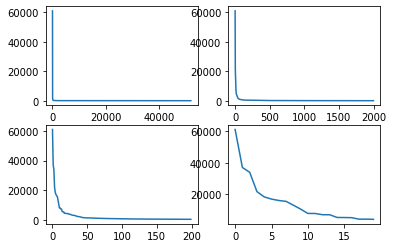

共有 51841 个不同的单词
[['the', 60960], ['What', 36995], ['of', 33987], ['in', 21785], ['to', 18443], ['was', 17065], ['is', 16198], ['did', 15634], ['what', 13219], ['a', 10753]]
874076


In [263]:
# TODO: 统计一下qlist中每个单词出现的频率，并把这些频率排一下序，然后画成plot. 比如总共出现了总共7个不同单词，而且每个单词出现的频率为 4, 5,10,2, 1, 1,1
#       把频率排序之后就可以得到(从大到小) 10, 5, 4, 2, 1, 1, 1. 然后把这7个数plot即可（从大到小）
#       需要使用matplotlib里的plot函数。y轴是词频
import matplotlib.pyplot as plt
from collections import Counter

y=[]
for i in word_dict:
    y.append(word_dict[i])
plt.subplot(221)
plt.plot(sorted(y,reverse=True))
plt.subplot(222)
plt.plot(sorted(y,reverse=True)[:2000])
plt.subplot(223)
plt.plot(sorted(y,reverse=True)[:200])
plt.subplot(224)
plt.plot(sorted(y,reverse=True)[:20])

plt.show()
value_sort = sorted(word_dict.values(), reverse=True)    
count_qlist_top =dict(zip(word_dict.values(), word_dict.keys()))
print ("共有 %d 个不同的单词"%word_total)
print([[count_qlist_top[v], v] for v in value_sort[:10]])
print(sum(word_dict.values()))


# counter=Counter()
# for text in alist:
#     counter.update(text.strip(' .!?').split(' '))
# alist_value_sort = sorted(counter.values(), reverse=True)
# count_alist_top =dict(zip(counter.values(), counter.keys()))
# print([[count_alist_top[v], v] for v in alist_value_sort[:10]])

In [264]:
# TODO： 从上面的图中能观察到什么样的现象？ 这样的一个图的形状跟一个非常著名的函数形状很类似，能所出此定理吗？ 
#       hint: [XXX]'s law
# 看出大概形状  齐普夫定律   r*n*常数c  r是排名  n是频次   c是常数
# 问题可能同质化  虚词过高  需要去停用词
# 排名靠前的有一些没意义
# 
# 

In [265]:
# TODO: 在qlist和alist里出现次数最多的TOP 10单词分别是什么？ 


In [266]:
# import nltk
# nltk.download('punkt')   
# nltk.download()

### 2.3 文本预处理
次部分需要尝试做文本的处理。在这里我们面对的是英文文本，所以任何对英文适合的技术都可以考虑进来。

In [267]:
# 分数（10）

# TODO: 对于qlist, alist做文本预处理操作。 可以考虑以下几种操作：
#       1. 停用词过滤 （去网上搜一下 "english stop words list"，会出现很多包含停用词库的网页，或者直接使用NLTK自带的）   
#       2. 转换成lo wer_case： 这是一个基本的操作   
#       3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
#       4. 去掉出现频率很低的词：比如出现次数少于10,20....
#       5. 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
#       6. stemming（利用porter stemming): 因为是英文，所以stemming也是可以做的工作
#       7. 其他（如果有的话）
#       请注意，不一定要按照上面的顺序来处理，具体处理的顺序思考一下，然后选择一个合理的顺序
#  hint: 停用词用什么数据结构来存储？ 不一样的数据结构会带来完全不一样的效率！ 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import math
sw = set(stopwords.words('english'))
sw -= {'who', 'when', 'why', 'where', 'how'}
sw.update(['\'s', '``', '\'\''])

ps = PorterStemmer()

def text_processing(text):
    seg=[]
    for word in word_tokenize(text):
        word =ps.stem(word.lower())
        word = "#number" if word.isdigit() else word
        if len(word)> 1 and word not in sw :
            seg.append(word)
    return seg
counter_qlist=Counter()
list_q=[]
for text in qlist:
    seg=text_processing(text)
    list_q.append(seg)
    counter_qlist.update(seg)

sorted_value=sorted(counter_qlist.values(),reverse=True)
min_tf = sorted_value[int(math.exp(0.99 * math.log(len(counter_qlist))))]
for  i in range(len(list_q)):
    list_q[i] = [word for word in list_q[i] if counter_qlist[word] > min_tf]
qlist=list_q
# qlist, alist =    # 更新后的
len(qlist)

86821

In [268]:
print(len(counter_qlist))

28170


In [269]:
print(sum(counter_qlist.values()))

530774


In [270]:
print(min_tf)

1


In [271]:
print(qlist[:10])

[['when', 'beyonc', 'start', 'becom', 'popular'], ['area', 'beyonc', 'compet', 'when', 'wa', 'grow'], ['when', 'beyonc', 'leav', 'destini', 'child', 'becom', 'solo', 'singer'], ['citi', 'state', 'beyonc', 'grow'], ['decad', 'beyonc', 'becom', 'famou'], ['group', 'wa', 'lead', 'singer'], ['album', 'made', 'worldwid', 'known', 'artist'], ['who', 'manag', 'destini', 'child', 'group'], ['when', 'beyoncé', 'rise', 'fame'], ['role', 'beyoncé', 'destini', 'child']]


In [272]:
# TODO: 在前面步骤里，我们删除了出现次数比较少的单词，那你选择的阈值是多少（小于多少的去掉？）， 这个阈值是根据什么来选择的？ 
# 
# 词频的过滤阈值是按照Zipf定律来算的，没见别人这么用过，自己感觉还算合理。

# Zipf's law一个实验定律，按照从最常见到非常见排列，第二常见的频率是最常见频率的出现次数的1/2，第三常见的频率是最常见的频率的1/3，
# 第n常见的频率是最常见频率出现次数的1/n。

# 假设我们文本的词频符合该定律，那么对1/n进行积分得到ln(n)，为了使99%的文本得到覆盖则需ln(x)>0.99*ln(n)，
# n是词type数，x是词频从高到底排列时的阈值分割点，最后x=e^(0.99*ln(n))。


### 2.4 文本表示
当我们做完关键的预处理过程之后，就需要把每一个文本转换成向量。

In [275]:
# 分数（10）

# TODO: 把qlist中的每一个问题字符串转换成tf-idf向量, 转换之后的结果存储在X矩阵里。 X的大小是： N* D的矩阵。 这里N是问题的个数（样本个数），
#       D是字典库的大小。 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform([' '.join(seg) for seg in qlist])


# vectorizer =  # 定义一个tf-idf的vectorizer

# X =   # 结果存放在X矩阵

In [276]:
# TODO: 矩阵X有什么特点？ 计算一下它的稀疏度

def sparsity_ratio(X):
    return 1.0 - X.nnz / float(X.shape[0] * X.shape[1])

print(X.shape)
print("input sparsity ratio:", sparsity_ratio(X))  # 打印出稀疏度(sparsity)
# print (sparsity)  # 打印出稀疏度(sparsity)

(86821, 14547)
input sparsity ratio: 0.9995936879973627


### 2.5 对于用户的输入问题，找到相似度最高的TOP5问题，并把5个潜在的答案做返回

In [281]:
# 分数（10）


from queue import PriorityQueue
def top5results(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    q_vector = vectorizer.transform([' '.join(text_processing(input_q))])
    print(q_vector.shape)
    sim = (X * q_vector.T).toarray()
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], cur))
        if len(pq.queue) > 5:
            pq.get()
        pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    
    top_idxs = [x[1] for x in pq_rank]
    return [alist[i] for i in top_idxs] 
#     top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
#                    # hint: 利用priority queue来找出top results. 思考为什么可以这么做？ 
    
#     return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

In [282]:
ts=[' '.join(text_processing("Which airport was shut down?"))]
print(ts)

['airport wa shut']


In [283]:
# TODO: 编写几个测试用例，并输出结果
print(top5results("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results("Which airport is closed?"))
print(top5results("What government blocked aid after Cyclone Nargis?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results("Which government stopped aid after Hurricane Nargis?"))

(1, 14547)
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'aerodrome with facilities for flights to take off and land', 'newspapers', 'various gaming sites']
(1, 14547)
['Plymouth City Airport', 'aerodrome with facilities for flights to take off and land', 'related', 'After the reunification', 'Nanjing Dajiaochang Airport']
(1, 14547)
['Myanmar', 'foreign aid', '10 days', 'the British government', 'The latent heat of water condensation amplifies convection']
(1, 14547)
['Myanmar', 'Isabel', 'foreign aid', 'Soviet Union and China', '10 days']


In [ ]:
# 分数（5）

# TODO: 上面的top5results算法的时间复杂度和空间复杂度分别是多少？

时间复杂度 = O()， 空间复杂度 = O()

### 2.6 利用倒排表的优化。 
上面的算法，一个最大的缺点是每一个用户问题都需要跟库里的所有的问题都计算相似度。假设我们库里的问题非常多，这将是效率非常低的方法。 这里面一个方案是通过倒排表的方式，先从库里面找到跟当前的输入类似的问题描述。然后针对于这些candidates问题再做余弦相似度的计算。这样会节省大量的时间。

In [285]:
from collections import defaultdict
 # 定一个一个简单的倒排表
inverted_idx = defaultdict(set)
for cur in range(len(qlist)):
    for word in qlist[cur]:
        inverted_idx[word].add(cur)



In [287]:
# 分数（10）

# TODO: 基于倒排表的优化。在这里，我们可以定义一个类似于hash_map, 比如 inverted_index = {}， 然后存放包含每一个关键词的文档出现在了什么位置，
#       也就是，通过关键词的搜索首先来判断包含这些关键词的文档（比如出现至少一个），然后对于candidates问题做相似度比较。
# 



def top5results_invidx(input_q):
    
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """
    input_seg=text_processing(input_q)
    candidates = set()
    for word in input_seg:
    # 取所有包含任意一个词的文档的并集
        candidates = candidates | inverted_idx[word]
    candidates = list(candidates)
    q_vector = vectorizer.transform([' '.join(input_seg)])
    sim = (X[candidates] * q_vector.T).toarray()
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], candidates[cur]))
        if len(pq.queue) > 5:
            pq.get()
    
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    print([x[0] for x in pq_rank])
    top_idxs = [x[1] for x in pq_rank]  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
    
    return [alist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案      

In [288]:
# TODO: 编写几个测试用例，并输出结果
print(top5results_invidx("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_invidx("Which airport is closed?"))
print(top5results_invidx("What government blocked aid after Cyclone Nargis?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_invidx("Which government stopped aid after Hurricane Nargis?"))

[1.0, 1.0, 0.6058098700501424, 0.5955903794475756, 0.5604486086527194]
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'aerodrome with facilities for flights to take off and land', 'newspapers', 'various gaming sites']
[0.7797154765957257, 0.7103241311289762, 0.7038747251719334, 0.6245909883904857, 0.5811739588019266]
['Plymouth City Airport', 'aerodrome with facilities for flights to take off and land', 'related', 'After the reunification', 'Nanjing Dajiaochang Airport']
[0.9999999999999998, 0.7852110277213404, 0.49331031138548853, 0.4162177525363464, 0.33229596712940707]
['Myanmar', 'foreign aid', '10 days', 'the British government', 'The latent heat of water condensation amplifies convection']
[0.5947629389746683, 0.39360612204759465, 0.35791876809775003, 0.31237667954304615, 0.29996990837431825]
['Myanmar', 'Isabel', 'foreign aid', 'Soviet Union and China', '10 days']


In [ ]:
# 分数（3）

# TODO: 上面的top5results算法的时间复杂度和空间复杂度分别是多少？

时间复杂度 = O()， 空间复杂度 = O()

### 2.7 基于词向量的文本表示
上面所用到的方法论是基于词袋模型（bag-of-words model）。这样的方法论有两个主要的问题：1. 无法计算词语之间的相似度  2. 稀疏度很高。 在2.7里面我们
讲采用词向量作为文本的表示。词向量方面需要下载： https://nlp.stanford.edu/projects/glove/ （请下载glove.6B.zip），并使用d=100的词向量（100维）。


In [293]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
# _ = glove2word2vec('glove.6B.100d.txt', 'glove2word2vec.6B.100d.txt')
model = KeyedVectors.load_word2vec_format('glove2word2vec.6B.100d.txt')
def docvec_get(seg):
    """
    将分词数据转为句向量。
    seg: 分词后的数据
    
    return: 句向量
    """
    vector = np.zeros((1, 100))
    size = len(seg)
    for word in seg:
        try:
            vector += model.wv[word]
        except KeyError:
            size -= 1
    
    return vector / size

X = np.zeros((len(qlist), 100))
for cur in range(X.shape[0]):
    X[cur] = docvec_get(qlist[cur])

# 计算X每一行的l2范数
Xnorm2 = np.linalg.norm(X, axis=1, keepdims=True)
X = X / Xnorm2

D:\soft\anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
D:\soft\anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [296]:
# 分数（10）

# TODO
# emb = # 读取每一个单词的嵌入。这个是 D*H的矩阵，这里的D是词典库的大小， H是词向量的大小。 这里面我们给定的每个单词的词向量，那句子向量怎么表达？
      # 其中，最简单的方式 句子向量 = 词向量的平均（出现在问句里的）， 如果给定的词没有出现在词典库里，则忽略掉这个词。

def top5results_emb(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q，转换成句子向量
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """

    # 用词向量后用词形还原更合理，此处就不做变更了
    seg = text_processing(input_q)
    # 直接用上边建好的倒排表
    candidates = set()
    for word in seg:
        # 取所有包含任意一个词的文档的并集
        candidates = candidates | inverted_idx[word]
    candidates = list(candidates)
    
    q_vector = docvec_get(seg)
    # 计算问题向量的l2范数
    qnorm2 = np.linalg.norm(q_vector, axis=1, keepdims=True)
    q_vector = q_vector / qnorm2
    # 计算余弦相似度，前边已经l2规范化过，所以直接相乘
    sim = (X[candidates] @ q_vector.T)

    # 使用优先队列找出top5
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], candidates[cur]))
        if len(pq.queue) > 5:
            pq.get()
    
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    print([x[0] for x in pq_rank])
    top_idxs = [x[1] for x in pq_rank]  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
    
    return [alist[i] for i in top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案     
    


In [297]:
# TODO: 编写几个测试用例，并输出结果
print(top5results_emb("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_emb("Which airport is closed?"))
print(top5results_emb("What government blocked aid after Cyclone Nargis?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_emb("Which government stopped aid after Hurricane Nargis?"))

# 我们在验收作业时在后台会建立几个测试用例，来验证返回的准确性。

D:\soft\anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()


[1.0, 1.0, 0.8875869259222657, 0.8826214612899685, 0.83558088872733]
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'Terminal C', 'Nanjing Dajiaochang Airport', '1967']
[0.9454294862808652, 0.9029611996952854, 0.9029611996952854, 0.9029611996952854, 0.8917413888585661]
['Plymouth City Airport', 'southern suburbs of Paris', 'within the departure areas', 'India', 'Dushanbe International Airport']
[1.0, 0.852360897734157, 0.8518187365307015, 0.8508247887568897, 0.8409244964740952]
['Myanmar', 'most Protestants (and most Jews)', 'lower house of parliament', 'the Tzu Chi Foundation', 'started an anti-separatist campaign']
[0.8828545495470352, 0.8348415264745357, 0.8166760602126991, 0.810772868269737, 0.7993383778232652]
['Myanmar', 'the Tzu Chi Foundation', 'started an anti-separatist campaign', 'public gaze', 'most Protestants (and most Jews)']


### 2.8 做完本次项目做完之后有什么收获？ 

#分数（2）

回答 = “”